In [1]:
# Basic imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("cpu")

cuda


In [2]:
# Load The Office script file
# Update this path to match your Kaggle dataset
with open('/kaggle/input/office-script-final/office_script_clean.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f"First 500 characters:\n{'-'*50}")
print(text[:500])
print(f"{'-'*50}")

First 500 characters:
--------------------------------------------------
Michael: All right Jim. Your quarterlies look very good. How are things at the library?
Jim: Oh, I told you. I couldn't close it. So...
Michael: So you've come to the master for guidance? Is this what you're saying, grasshopper?
Jim: Actually, you called me in here, but yeah.
Michael: All right. Well, let me show you how it's done.
Michael:  Yes, I'd like to speak to your office manager, please. Yes, hello. This is Michael Scott. I am the Regional Manager of Dunder Mifflin Paper Products. Just w
--------------------------------------------------


In [3]:
# Get all unique characters from the script
chars = sorted(set(text))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

vocab_size = len(chars)
print(f"Vocabulary created with {vocab_size} unique characters")
print(f"Sample characters in vocabulary: {''.join(chars[:50])}...")

# Encode the entire text as numbers
encoded = [char_to_idx[ch] for ch in text]
data = torch.tensor(encoded, dtype=torch.long)
print(f"Encoded text shape: {data.shape}")

Vocabulary created with 72 unique characters
Sample characters in vocabulary: 
 !',-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcd...
Encoded text shape: torch.Size([3427466])


In [4]:
# Settings for our model
SEQ_LEN = 100  # How many previous characters to look at
BATCH_SIZE = 256  # Process this many sequences at once

# Split data into training (90%) and testing (10%)
split_idx = int(len(data) * 0.9)
train_data = data[:split_idx]
test_data = data[split_idx:]

print(f"Training data: {len(train_data):,} characters")
print(f"Testing data: {len(test_data):,} characters")

# Create sequences for training
def create_sequences(data, seq_len):
    sequences = []
    targets = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
        targets.append(data[i+seq_len])
    return torch.stack(sequences), torch.stack(targets)

X_train, y_train = create_sequences(train_data, SEQ_LEN)
X_test, y_test = create_sequences(test_data, SEQ_LEN)

print(f"Training sequences: {X_train.shape}")
print(f"Testing sequences: {X_test.shape}")

Training data: 3,084,719 characters
Testing data: 342,747 characters
Training sequences: torch.Size([3084619, 100])
Testing sequences: torch.Size([342647, 100])


In [5]:
# Create PyTorch datasets and data loaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 12050
Testing batches: 1339


In [6]:
class OfficeLSTM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Embedding layer converts character indices to vectors
        self.embed = nn.Embedding(vocab_size, 128)
        
        # LSTM layers - the main processing
        self.lstm = nn.LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
        
        # Output layer predicts next character
        self.fc = nn.Linear(256, vocab_size)
        
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        x = self.embed(x)  # (batch_size, seq_len, 128)
        
        # LSTM processing
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Take only the last time step's output
        lstm_out = lstm_out[:, -1, :]  # (batch_size, 256)
        
        # Final prediction
        output = self.fc(lstm_out)  # (batch_size, vocab_size)
        
        return output, hidden

# Create the model
model = OfficeLSTM(vocab_size).to(device)


In [9]:
# Setup for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track losses for plotting
train_losses = []
val_losses = []


# Train for 15 epochs 
for epoch in range(15):
    
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output, _ = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output, _ = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)
            
            _, predicted = torch.max(output, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    # Calculate averages
    avg_train_loss = train_loss / len(train_dataset)
    avg_val_loss = val_loss / len(test_dataset)
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Calculate perplexity
    train_perplexity = np.exp(avg_train_loss)
    val_perplexity = np.exp(avg_val_loss)
    
    
    print(f"Epoch {epoch+1:2d}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"  Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Val Perplexity: {val_perplexity:.4f}")
 

Epoch  1
  Train Loss: 1.2211 | Val Loss: 1.2576
  Train Acc: 0.6171 | Val Acc: 0.6068
  Val Perplexity: 3.5169
Epoch  2
  Train Loss: 1.1956 | Val Loss: 1.2483
  Train Acc: 0.6238 | Val Acc: 0.6092
  Val Perplexity: 3.4845
Epoch  3
  Train Loss: 1.1815 | Val Loss: 1.2414
  Train Acc: 0.6276 | Val Acc: 0.6126
  Val Perplexity: 3.4603
Epoch  4
  Train Loss: 1.1717 | Val Loss: 1.2331
  Train Acc: 0.6305 | Val Acc: 0.6167
  Val Perplexity: 3.4319
Epoch  5
  Train Loss: 1.1650 | Val Loss: 1.2321
  Train Acc: 0.6319 | Val Acc: 0.6141
  Val Perplexity: 3.4284
Epoch  6
  Train Loss: 1.1603 | Val Loss: 1.2282
  Train Acc: 0.6332 | Val Acc: 0.6169
  Val Perplexity: 3.4149
Epoch  7
  Train Loss: 1.1568 | Val Loss: 1.2263
  Train Acc: 0.6342 | Val Acc: 0.6170
  Val Perplexity: 3.4085
Epoch  8
  Train Loss: 1.1544 | Val Loss: 1.2267
  Train Acc: 0.6349 | Val Acc: 0.6171
  Val Perplexity: 3.4098
Epoch  9
  Train Loss: 1.1524 | Val Loss: 1.2248
  Train Acc: 0.6355 | Val Acc: 0.6164
  Val Perplexity:

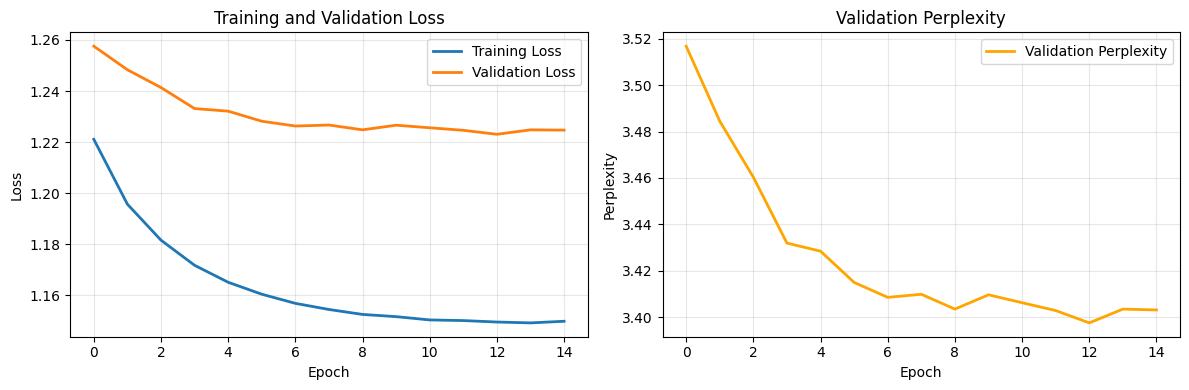

Final Validation Perplexity: 3.4030


In [10]:
# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot perplexity
train_ppl = [np.exp(loss) for loss in train_losses]
val_ppl = [np.exp(loss) for loss in val_losses]
ax2.plot(val_ppl, label='Validation Perplexity', linewidth=2, color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Validation Perplexity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final perplexity
final_perplexity = np.exp(val_losses[-1])
print(f"Final Validation Perplexity: {final_perplexity:.4f}")

In [11]:
def sample_with_temperature(logits, temperature=1.0):
    #Sample next character using temperature.
    #Low temperature = more predictable, high temperature = more random.
    
    if temperature <= 0:
        # Just take the most likely character
        return torch.argmax(logits).item()
    
    # Adjust probabilities with temperature
    logits = logits / temperature
    
    # Convert to probabilities
    probs = torch.softmax(logits, dim=-1)
    
    # Sample from the distribution
    return torch.multinomial(probs, 1).item()

In [12]:
def generate_script(seed_text, temperature=1.0, num_chars=500):
 
    model.eval()
    generated_text = seed_text
    
    # Start with seed text
    current_seq = seed_text[-SEQ_LEN:] if len(seed_text) > SEQ_LEN else seed_text
    
    with torch.no_grad():
        hidden = None
        
        for _ in range(num_chars):
            # Convert current sequence to tensor
            x = torch.tensor([[char_to_idx[ch] for ch in current_seq]], 
                           dtype=torch.long, device=device)
            
            # Get model predictions
            logits, hidden = model(x, hidden)
            logits = logits[0]  # Remove batch dimension
            
            # Sample next character
            next_idx = sample_with_temperature(logits, temperature)
            next_char = idx_to_char[next_idx]
            
            # Add to generated text
            generated_text += next_char
            
            # Update current sequence
            current_seq = current_seq[1:] + next_char
    
    return generated_text

# Testing the function
test_output = generate_script("Michael: ", temperature=0.7, num_chars=100)
print(f"Generated: {test_output[:150]}...")

Generated: Michael: That was the book to other to get the dollars that I wanted to good to have an idea.
Michael: It was...


In [13]:

# Test different temperatures
temperatures = [0.3, 0.7, 1.0]
seed = "Michael: I have an announcement. "

for temp in temperatures:
    print(f"\n--- Temperature: {temp} ---")
    generated = generate_script(seed, temperature=temp, num_chars=300)
    
    print("Generated text:")
    print(generated)
    print()


--- Temperature: 0.3 ---
Generated text:
Michael: I have an announcement. I was thinking about the seconds.
Michael: Yes.
Pam: I don't know what I was thinking. I don't know what I was a second.
Jim: I don't know what you were too much.
Pam: I know what I was waiting to take the last time they can be the best day. And I would like to see the guy who has a little bit of th


--- Temperature: 0.7 ---
Generated text:
Michael: I have an announcement. You're cool. That's what if you want to be on the bore? Huh? You know what? Who are you?
Michael: Well...
Dwight: What the hell be? Okay?
Jim: I want anything to come back to the people. Do you want to get in the week?
Michael: That's what's too cool.
Pam: So, uh, well, I think I don't have to fall 


--- Temperature: 1.0 ---
Generated text:
Michael: I have an announcement. Although, I was gonna work on it. You know what? I said, yeah, I can't- 
Michael: I don't. I just wanted to need our perfectismences on movies.
Michael: Oh, yeah. Uh, you 

In [14]:
# Calculate final test perplexity
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output, _ = model(batch_x)
        test_loss += criterion(output, batch_y).item() * batch_x.size(0)

avg_test_loss = test_loss / len(test_dataset)
test_perplexity = np.exp(avg_test_loss)

print(f"Final Test Perplexity: {test_perplexity:.4f}")

# Generate best sample

best_seed = "Michael: Okay everyone, listen up. "
best_temperature = 0.7
best_sample = generate_script(best_seed, temperature=best_temperature, num_chars=500)

print(f"Seed text: '{best_seed}'")
print(f"Temperature used: {best_temperature}")
print(f"Perplexity score: {test_perplexity:.4f}")
print(f"\nGenerated Script:")
print(best_sample)


Final Test Perplexity: 3.4030
Seed text: 'Michael: Okay everyone, listen up. '
Temperature used: 0.7
Perplexity score: 3.4030

Generated Script:
Michael: Okay everyone, listen up. The boss for the boss, it's for the most meatball. And you know what? Yeah, back. And I have a pen1s out. And then we all take the world. But it's a what when you talk about the one clients of the company since it's hot these over the prices.
Darryl:  That's very good.
Michael: Well, I would like to take my eyes or... you will let you make a pretty smart. But I was gonna get a little bit that was a job off. And they're gonna be insurance. Wouldn't he see it?
Pam: And it was a good day.
Michael: 


In [15]:

print("""
From the generated samples at different temperatures:

Temperature 0.3:
- Very safe and predictable
- Repeats common patterns from the training data
- Good grammar but not very creative

Temperature 0.7:
- Best balance between creativity and coherence
- Generates new dialogue that still sounds like The Office
- Good for generating script-like text

Temperature 1.0:
- More random and creative
- Sometimes produces funny or unexpected results
- Might make grammatical mistakes but can be more entertaining

""")


From the generated samples at different temperatures:

Temperature 0.3:
- Very safe and predictable
- Repeats common patterns from the training data
- Good grammar but not very creative

Temperature 0.7:
- Best balance between creativity and coherence
- Generates new dialogue that still sounds like The Office
- Good for generating script-like text

Temperature 1.0:
- More random and creative
- Sometimes produces funny or unexpected results
- Might make grammatical mistakes but can be more entertaining


